# Select wildfire burn area predictors 

### This will be done using Laso 

This notebook will be used to see how laso selection works. I am going to see what met predictors work best at accounting for wildfire burn area for each grid box. I am going to insert random nonsense into the predictor matrix as a way to test that I know what laso is doing and to ensure that these random predictors are discarded... If they are not, then these methods do not work as I understan or hoped. 

Show predicted values vs actual for the data used to create the model and the data I set aside. 

Use every environmental variable available as a predictor (e.g. T, Tp, RH, ScfWind, VPD, ...), then, create lagged versions of these data as predictors as well. For example, shift the environmental arrays by minus one month, so that the month before the burn area occurs is used as the predictor. Do this for different time lags. Do this the other way too to help determine the validity of our methods. If temperature 5 months after a wildfire is the best predictor of wildfire occurrence, the model is doing something that can not represent an actual environmental predictor. 

TODO: Should I consider using random years worth of data with Lasso and testing performance on the other half of the random years for learning purposes? Yes. 

In [1]:
# Import needed libraries and paths to local fire and Met Data
import numpy as np
from netCDF4 import Dataset
import os
%matplotlib inline
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, Lasso
from sklearn import datasets
import time
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
# Modules I have written 
import model_dictionary as md # md, you know, like the helpful kind of doctor
import random

# Set the spatial domain of analysis:
minX=235.
maxX=258.
minY=31.
maxY=49.

### In our work, we are interested in predicting total summer burn area. 

#### Lets start by selecting the besy predictors for June, July, August burn area

In [2]:
# Get the values we need to predict, burn area. This is the target. 
# We want to estimate the unknown target function. 
def get_FPA_FOD_csv_data(minX=235., maxX=258., minY=31., maxY=49.) :
    
    """Loads FPA FOD burn area data into the workspace."""
    
    burnFile = os.path.join("..", "Data", "Fire", "FPA_FOD", 'FPA_FOD_monthly_1992_2015_with_LC_COMMON_GRID.nc')
    nc = Dataset(burnFile, 'r')
    BA = nc.variables['burn_area'][:]
    t = nc.variables['time'][:]
    LC = nc.variables['LC'][:]
    x = nc.variables['lon'][:]
    y = nc.variables['lat'][:]
    nc.close()

    # Get an array to allow easy subsetting of time
    t_fire = pd.date_range("1992-01-01", periods=len(t), freq="M")

    # Spatially subset these data to the western US 
    lonIndex = np.where( ( (x >= minX) & (x <= maxX)) )[0]
    latIndex = np.where( ( (y >= minY) & (y <= maxY) ) )[0]
    timeIndex = range(BA.shape[0]) # dummy index to retain all time dimensions
    LC_index = range(len(LC))
    
    x_subset = x[lonIndex]
    y_subset = y[latIndex]
    BA_subset = BA[np.ix_(timeIndex, latIndex, lonIndex, LC_index)]
    
    return BA_subset, t_fire, x_subset, y_subset, LC 

#### Visualize total burn area and seperate by land cover type for lasso regression

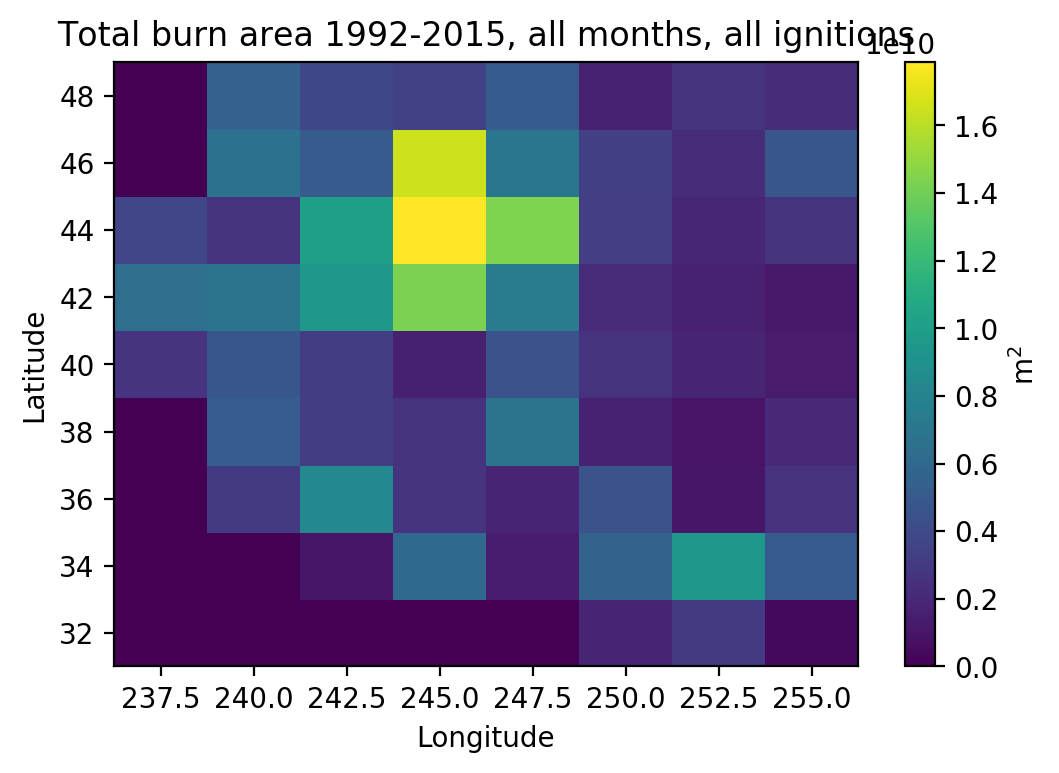

In [3]:
# Get the gridded FPA FOD burn area data [time, lat, lon, LC]
BA, t_fire, lon, lat, LC  = get_FPA_FOD_csv_data(minX, maxX, minY, maxY)

plt.figure(dpi=200)
plt.pcolor(lon, lat, np.sum(BA, axis=(0, 3)))
plt.colorbar(label="m$^{2}$")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Total burn area 1992-2015, all months, all ignitions")
plt.show()

### Subset BA array by land cover categories of interest. 
https://landcover.usgs.gov/global_climatology.php

In [4]:
LC_category_dict = {
    "all"    : [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
    "forest" : [1,2,3,4,5],
    "shrubs" : [6,7],
    "grass"  : [10] 
}

# Create a dictionary that will store the total burn area for these
# land cover categories. 
BA_dict = {}
for lc in LC_category_dict.keys() :
    # BA[t, lat, lon, LC]
    BA_dict[lc] = BA[:,:,:, LC_category_dict[lc] ]
    print(lc, BA_dict[lc].shape)

('all', (288, 10, 9, 17))
('grass', (288, 10, 9, 1))
('forest', (288, 10, 9, 5))
('shrubs', (288, 10, 9, 2))


#### Sum burn area for land cover types of interest in the loaded domain.
* Transforms gridded burn area data into array of monthly totals for the domain for land covers of interest. 

In [6]:
# Sum the burn area in the chosen domain 
BA_monthly_dict = {}
for lc in BA_dict.keys() : 
    BA_monthly_dict[lc] = np.sum(BA_dict[lc], axis=(1,2,3))
    print(lc, BA_monthly_dict[lc].shape)

('all', (288,))
('grass', (288,))
('forest', (288,))
('shrubs', (288,))


#### Show the time series of these data. 

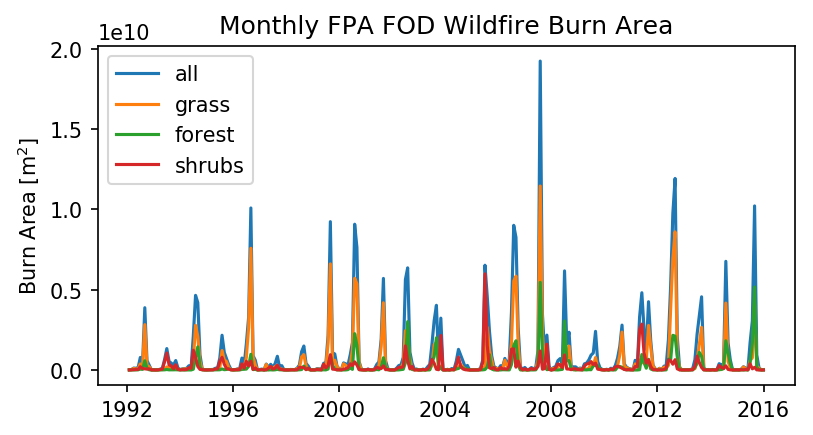

In [7]:
plt.figure(figsize=(6,3), dpi=150)
for lc in BA_monthly_dict.keys() :
    plt.plot(t_fire, BA_monthly_dict[lc], label=lc) 
plt.legend()
plt.ylabel("Burn Area [m$^{2}$]")
plt.title("Monthly FPA FOD Wildfire Burn Area")
plt.show()

#### Create a function for loading corresponding era-interim data

In [8]:
# Get era-interim nc data entire western US spatial averages 
def get_era_nc_vals(var="t2m", minX=235., maxX=256., minY=31., maxY=49., spatialMean=False, startYear=1992):
    """This function will be for loading a particular nc file, which will be spatially subset.
    The defualt latitude longitude values cover the western US.
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1990-2015.nc" 

    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 312):
        # Convert to pandas time array, on the assumption t[0]=1990-01-01 and t[-1]=2015-12-01
        # 26 years times 12 months per year makes for 312 months expected in these arrays
        t_mon = pd.date_range("1990-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 312 expected.")
        
    # Now subset the data based on the passed max and min values for lon and lat
    lonIndex = np.where( ((lon >= minX) & (lon <= maxX)) )[0]
    latIndex = np.where( ( (lat >= minY) & (lat <= maxY) ) )[0]
    
    # Where is the first month of startYear
    t_first = np.where(t_mon.year == startYear)[0][0]
    
    # because we want all months, for now, but starting in startYear
    timeIndex = range(t_first, len(t)) 

    # Subset the 2D field
    lonCut = lon[lonIndex]
    latCut = lat[latIndex]
    t_monCut = t_mon[timeIndex]

    # Subset the 3D field
    valsCut = vals[np.ix_(timeIndex, latIndex, lonIndex)]

    # take a spatial mean? 
    if spatialMean:
        valsCut = np.mean(valsCut, axis=(1,2))
    
    return valsCut, t_monCut, lonCut, latCut

#### Load desired features, place in df, normalize. 

In [9]:
predictors = ["t2m", "tp", "si10", "RH", "ssrd", "VPD"] # aka features 
predictorDict = {}
for var in predictors:
    predictorDict[var], t, lon, lat = get_era_nc_vals(var=var, spatialMean=True)

# Features used to estimate the target function    
X = pd.DataFrame(predictorDict)

# TODO: Make sure this is the most sensible way to standardize these data
# TODO: Double check the scikitlearn documentation
Z = (X - np.mean(X)) / np.std(X)

### Setup summer forecasting using seasonal (varying t-lag) predictors

##### Predictors (aka features)
- summer, spring, winter,  temperature
-  ...

In [41]:
# Create summer burn area time series
years  = np.sort(np.unique(t_fire.year))
nYears = len(years)
BA_summer_dict = {}
for lc in BA_monthly_dict.keys():
    BA_summer_dict[lc] = np.zeros(nYears)

# Create season masks (first month last month of season). Each season gets its own 
# column in the features DataFrame.
# NOTE: Make sure to not use months after wildfires in a given year, e.g. 
# NOTE: December, unless set to the year before # Make sure to not use months 
# NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
month = pd.Series(t.month)
seasons = {"winter":[1,2], 
           "spring":[3,4,5], 
           "summer":[6,7,8,9]}

# Make a dictionary to store predictors for each variable for each season 
# of interest. 
# TODO: Nino-index as a predictor? 
variables = ["t2m", "tp", "si10", "RH", "VPD"]
predictor_dict = {} # To store predictor information 
for pre in variables:
    for s in seasons.keys():
        predictor_name = pre + "_" + s 
        predictor_dict[predictor_name] = np.zeros(nYears)
        
# Loop through each year, assigning desired season predictor value 
# within each year 
for i in range(nYears):
        
    # Mask the year of interest, 0 through nYears  
    year_mask = years[i] == t.year
    
    # Loop through seasons, within a year
    for s in seasons.keys():
        
        # Mask the months that fall into the current season of interest
        month_mask = month.isin(seasons[s])

        # combine to make a single mask
        tChunk = month_mask & year_mask 

        # Take desired stats (mean or sum) of these temporal chunk
        if s == "summer":
            for lc in BA_summer_dict.keys() :
                BA_summer_dict[lc][i] = np.sum(BA_monthly_dict[lc][tChunk])
            #print(t[tChunk])

        # For each predictor variable, loop through taking relevant stat
        # TODO: consider an if statement to take sums vs. means of variables
        # TODO: See if .loc is better for subsetting DataFrame X
        for pre in variables:
            predictor_dict[pre+"_"+s][i] = np.mean(X.loc[tChunk, pre])
    
# Assign the summer values to a Features DataFrame. Here, I switch
# to some more math-ish language. 
df_features = pd.DataFrame(predictor_dict)
df_targets  = pd.DataFrame(BA_summer_dict)
    
# This is now a nice Dataframe, so we can get rid of the outdated dict. 
del predictor_dict, BA_summer_dict

# Show the features that will be used for prediction
df_features

,RH_spring,RH_summer,RH_winter,VPD_spring,VPD_summer,VPD_winter,si10_spring,si10_summer,si10_winter,t2m_spring,t2m_summer,t2m_winter,tp_spring,tp_summer,tp_winter
0,55.501331,48.507793,69.892487,676.902893,1238.405151,262.262909,3.387895,3.355550,3.301147,284.886432,292.047154,276.909924,0.066417,0.045479,0.079667
1,58.740406,50.976173,74.296608,615.655823,1128.809082,201.175476,3.653267,3.504146,3.471268,283.795386,290.986219,273.868765,0.080030,0.053399,0.115552
2,54.951214,43.415512,66.229370,653.250183,1494.042236,288.578796,3.616241,3.365082,3.454389,283.972804,293.244360,275.468642,0.057922,0.022861,0.074144
3,60.585571,49.474907,72.885254,521.595459,1243.115723,244.760895,3.847413,3.386811,3.394641,282.232854,291.917920,277.196900,0.099785,0.045364,0.108752
4,56.281628,46.270874,68.262878,653.216431,1364.721436,283.076447,3.946157,3.414682,3.734538,282.957249,292.455015,275.795501,0.071740,0.028663,0.105934
5,55.700245,51.996761,70.435738,658.580811,1193.626221,256.941010,3.820725,3.395253,3.620840,283.325044,292.377952,275.472871,0.063800,0.052203,0.088084
6,60.268215,50.431099,73.592522,521.634338,1261.677979,230.444305,3.614509,3.246826,3.731214,282.212880,292.660454,276.332312,0.079334,0.036045,0.131238
7,55.437603,49.340408,65.969704,583.499268,1191.266235,310.079193,4.042327,3.342825,3.938518,282.114755,291.551964,276.506138,0.066840,0.033307,0.096741
8,54.544891,46.065357,68.996674,692.509583,1376.906738,288.298401,3.843377,3.400272,3.516572,283.833492,292.603797,276.715664,0.057230,0.024450,0.094454
9,55.065189,46.526154,69.624619,677.591003,1376.526733,243.708725,3.707752,3.292998,3.345843,283.514729,292.797953,274.548534,0.052965,0.031410,0.059835


In [42]:
df_targets

,all,forest,grass,shrubs
0,5.638919e+09,7.704140e+08,3.685451e+09,4.193656e+08
1,2.587592e+09,5.305289e+07,5.650539e+08,1.698268e+09
2,1.191294e+10,2.458844e+09,5.994298e+09,2.271757e+09
3,4.698106e+09,1.238285e+08,2.480000e+09,1.777243e+09
4,1.590153e+10,1.286482e+09,1.180610e+10,1.371172e+09
5,1.588439e+09,6.020525e+07,6.416463e+08,5.135794e+08
6,3.344011e+09,3.646050e+08,2.138108e+09,4.916075e+08
7,1.287610e+10,1.291107e+09,8.842666e+09,1.406663e+09
8,1.894586e+10,3.841988e+09,1.275205e+10,1.111436e+09
9,8.692450e+09,1.134415e+09,6.190439e+09,4.794053e+08


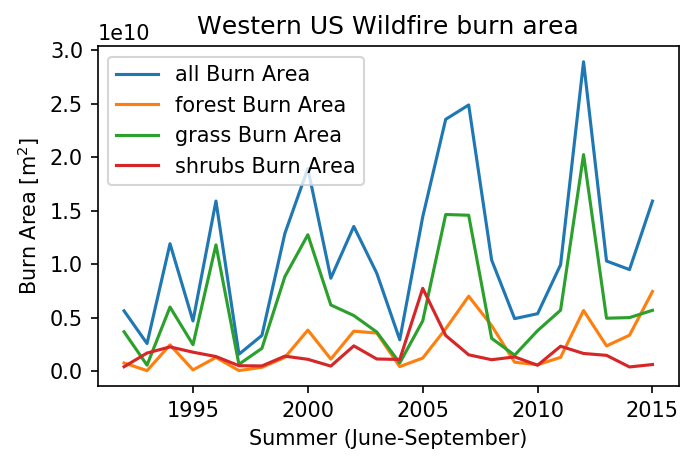

In [50]:
plt.figure(dpi=150., figsize=(5,3))
for target in df_targets.columns :
    plt.plot(years, df_targets[target], label=target + " Burn Area")
plt.title("Western US Wildfire burn area")
plt.ylabel("Burn Area [m$^{2}$]")
plt.xlabel("Summer (June-September)")
plt.legend()
plt.show()

#### Normalize the features for summer burn area prediction

In [54]:
# TODO: Figure out if this is a better method: sklearn.preprocessing.StandardScaler()
def norm_data(X) :
    """A function for taking a matrix or dataframe and making columns
    have unit variance and a mean value of 0."""
    Z = (X - np.mean(X)) / np.std(X)
    return(Z)

In [71]:
def plot_coefs(target, model, Z):
    """A function for plotting the coefs found by the regression."""
    #plt.figure(dpi=150, figsize=(10,5))
    plt.bar(x=Z.columns, height=model.coef_)
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coef")
    plt.title(target + " land cover burn area predictors, $\\alpha$=" + str(np.round(model.alpha_,5)))
    #plt.show()

#### Use out of the box, LassoCV for desired targets. 
* Are the coeficients different for different land cover values within the same spatial domain (i.e.) exact same predictor features
* Coefficients represent relative importance in the model.
* Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. Alpha = 0 is OLS regression. 

#### How consisten are these coeficients with existing literature??

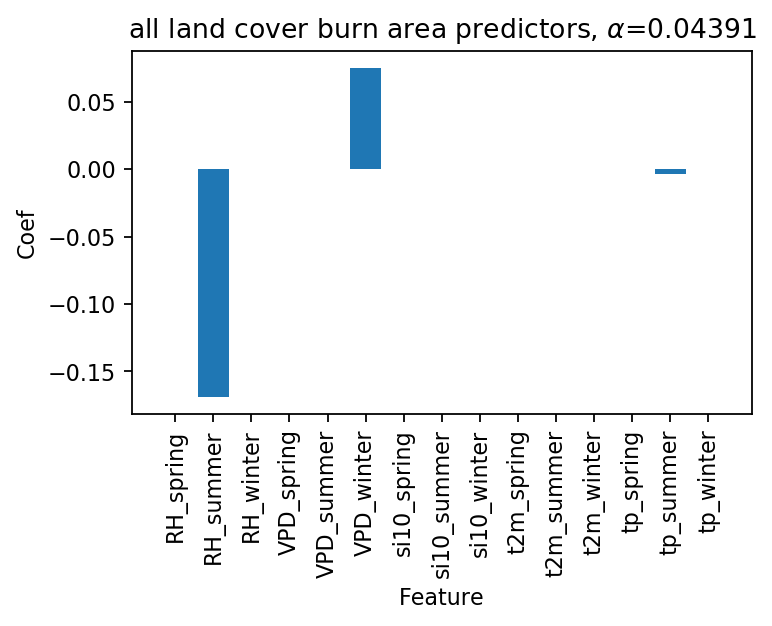

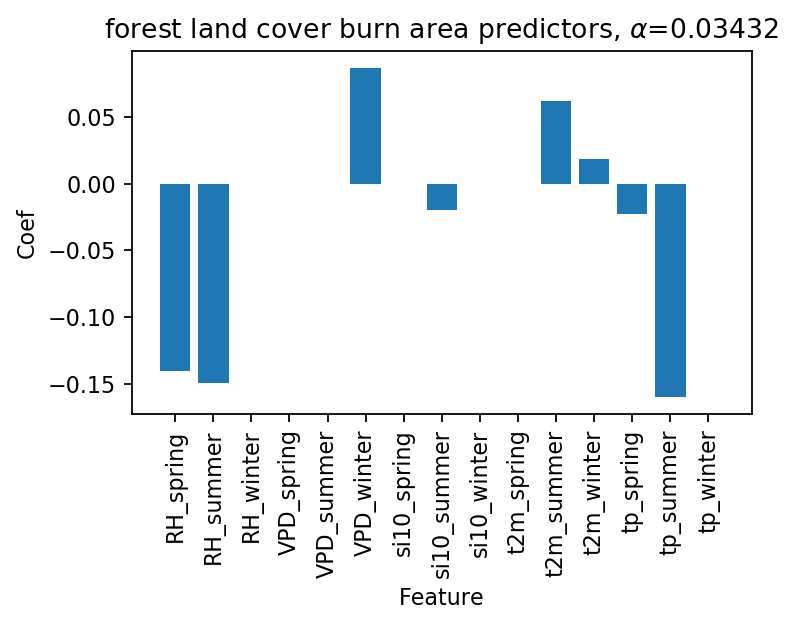

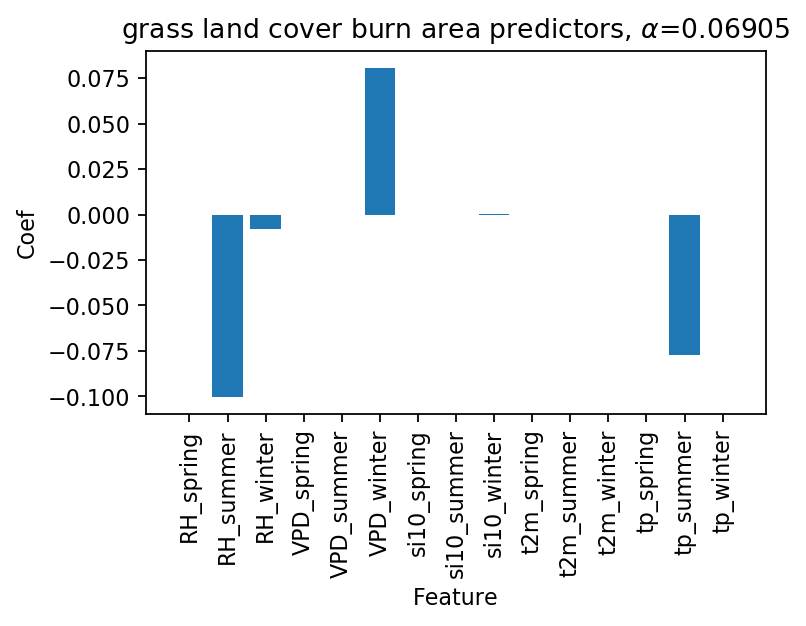

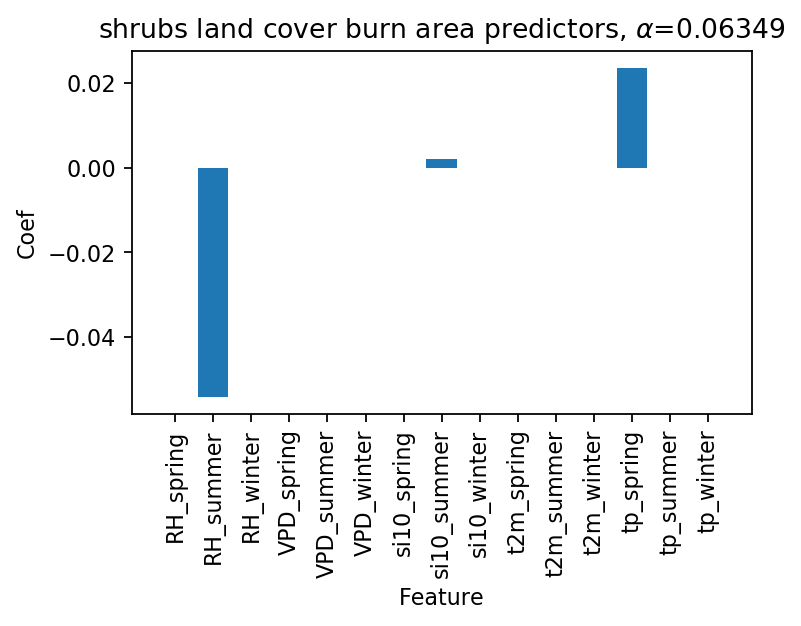

In [72]:
# Normalize the predictor features
Z = norm_data(df_features)

# Use Lasso CV to create a model using all outlined features. 
model_cv_dict = {}
for target in df_targets.keys() : 
    
    y = np.log10(df_targets[target])
    model_cv_dict[target] = LassoCV(cv=4).fit(Z, y) 
    
    plt.figure(dpi=160, figsize=(5,3))
    plot_coefs(target, model_cv_dict[target], Z)
    plt.show()

### Implement a custom cross validation scheme that minimizes out of sample error
* Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. Alpha = 0 is OLS regression. 

for alpha value in a range

    for leaving a year out: (1992:2015):
        
        leave_one_out_model = Lasso(alpha, these years of targets and predictors)
        save mean square error
        save the coefs
     
     Calculate mean error for this alpha

In [110]:
def leave_one_out_cv(y, Z, years, alphas):
    """Function for finding the alpha that minimizes the square error
    on years left out cross validation for lasso regressions."""
    
    # Keep track of the out of sample error for the left out year
    # whos burn area is predicted. 
    error_df = pd.DataFrame(index=alphas, columns=years)

    for alpha in alphas:
        # The "year" is the year that is left out of the features
        # and is predicted. It is what I use to estimate the out
        # of sample error. 
        for year in years:

            # Mask out this year of data and make the model without it. 
            test_year = pd.Series(years).isin([year])
            training_years = [not i for i in test_year]

            # Get rid of year from the features and target
            Z_subset = Z.loc[training_years,:]
            y_subset = y[training_years]

            # Make the model
            model = Lasso(alpha=alpha).fit(Z_subset, y_subset)
            
            # Use the model to predict values for the year left out of the model
            # i.e. use the coefs to guess the left out year. 
            predicted_value = model.predict(Z.loc[test_year])
            
            # Calculate the square error 
            error = ((predicted_value - y[test_year])[0])**2

            # Store the error of the model 
            error_df.at[alpha, year] = error

    # Take the mean error of each row 
    alpha_mean_error = error_df.mean(axis=1)
    min_error_row = np.argmin(alpha_mean_error.values)
    alpha_best = alphas[min_error_row]
    
    return alpha_mean_error, min_error_row, alpha_best 



In [109]:
np.argmin([1,2,3,4,5,-100,10,20])

5

Finding alpha for all
Finding alpha for forest
Finding alpha for grass
Finding alpha for shrubs


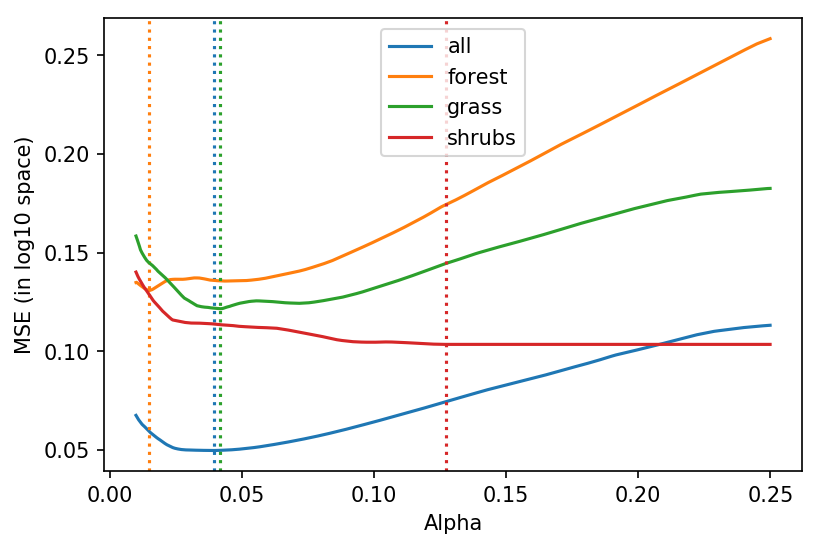

In [119]:
# Alphas to make models for
alphas = np.arange(0.01, 0.25, 0.0001)

# Tableau color pallete. 
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

alpha_CV_dict = {}
plt.figure(dpi=150)
i = 0
for target in df_targets.keys() :
    
    print("Finding alpha for "+ target. " lands")
    # Get the target- log10 transformed
    y = np.log10(df_targets[target].values)
    alpha_mean_error, min_error_row, alpha_best = leave_one_out_cv(y, Z, years, alphas)
    
    # Save the alpha that had the minimim square error
    alpha_CV_dict[target] = alpha_best
    
    # Show the error and location of best alpha 
    plt.plot(alphas, alpha_mean_error, c=line_colors[i], label=target)
    plt.axvline(x=alpha_best, c=line_colors[i], linestyle=":")
    i+=1         
        
plt.xlabel("Alpha")
plt.ylabel("MSE (in log10 space)")
plt.title("Square error vs. Alpha")
plt.legend()
plt.show()

In [147]:
def show_model_skill(target, y, Z, alpha_best, years):
    """
    Predict historical values using optimal alphas.
    plot the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
    """
    
    # Using alpha best and predictors, create fit
    model_best = Lasso(alpha=alpha_best).fit(Z, y)
    
    # Make prediction
    y_hat = model_best.predict(Z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(10,10))
    
    fig.suptitle(target + " land cover regression summary", fontsize=14)
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 2, 1)
    plt.bar(x=Z.columns, height=model_best.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model_best.alpha, 4)))
    #plt.show()

    ########################################
    # Plot obs and modeled values for both
    ########################################
    plt.subplot(2, 2, 2)
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.plot(years, y, label="observation")
    plt.scatter(years, y, s=15)
    plt.plot(years, y_hat, label="model, r$^{2}$=" + str(r2), linestyle=":")
    plt.ylabel("log$_{10}$(burn area m$^{2}$)")
    plt.legend()
    plt.title("Time series of data and estimates")
    #plt.show()

    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 2, 3)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))
    #plt.colorbar(label="Year")

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 2, 4)
    plt.scatter(years, y-y_hat, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    plt.ylabel("log$_{10}$(burn area m$^{2}$)")
    plt.title("Model residuals")
    plt.colorbar()
    
    plt.subplots_adjust(hspace=0.6)
    plt.show()

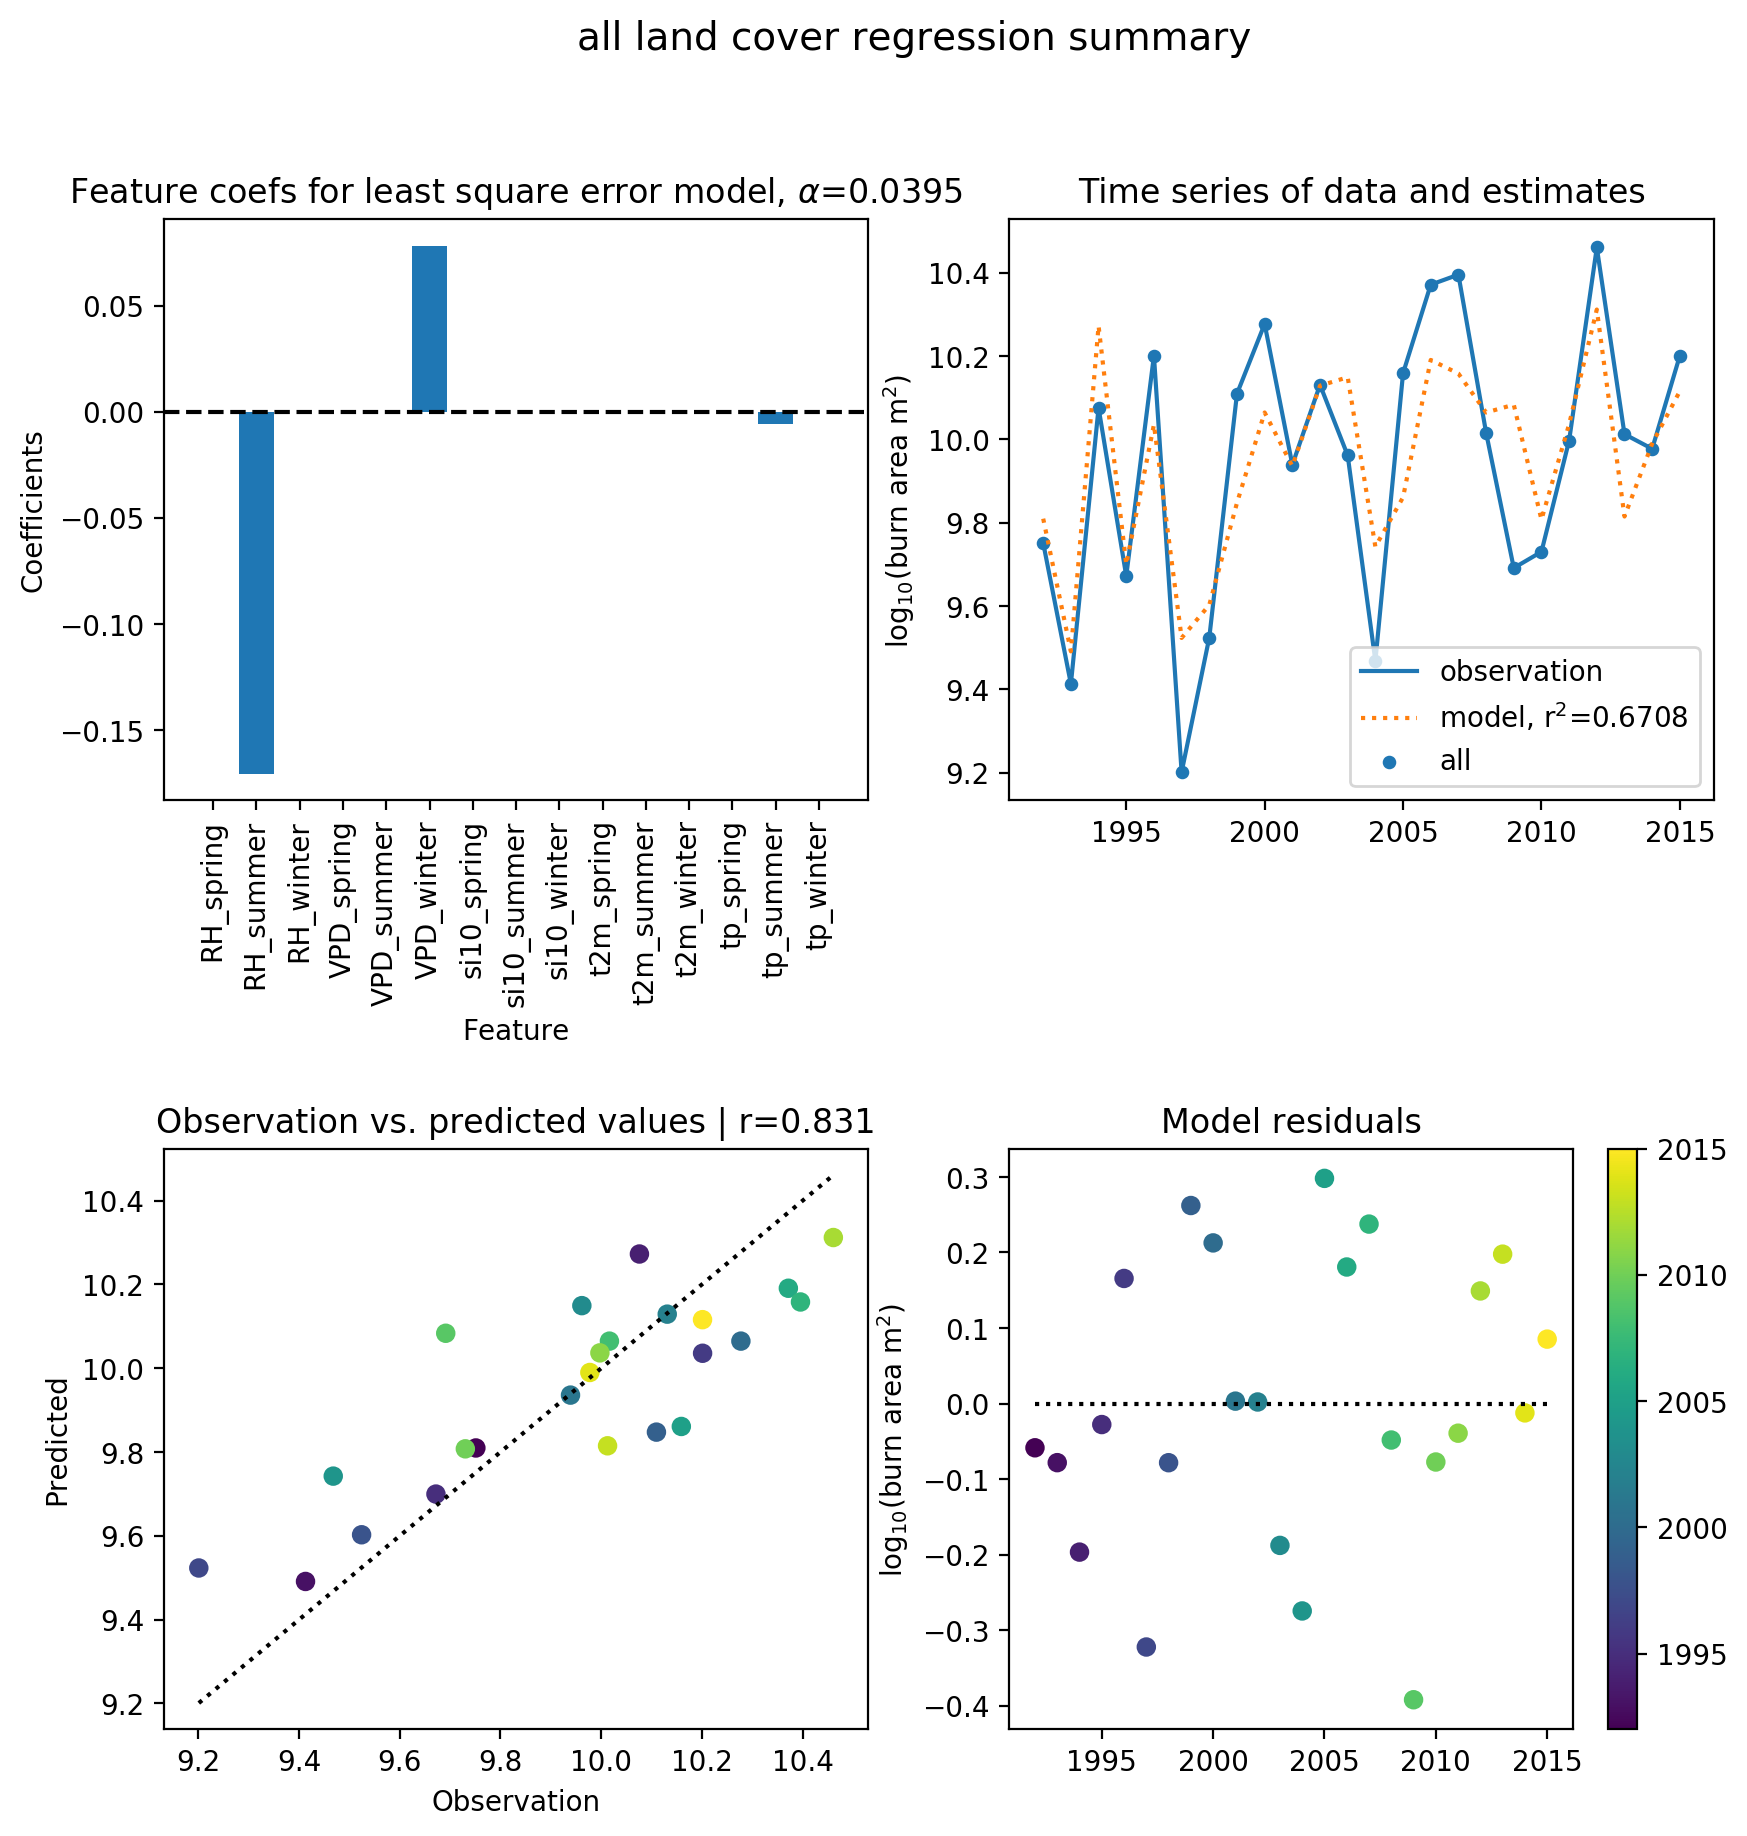

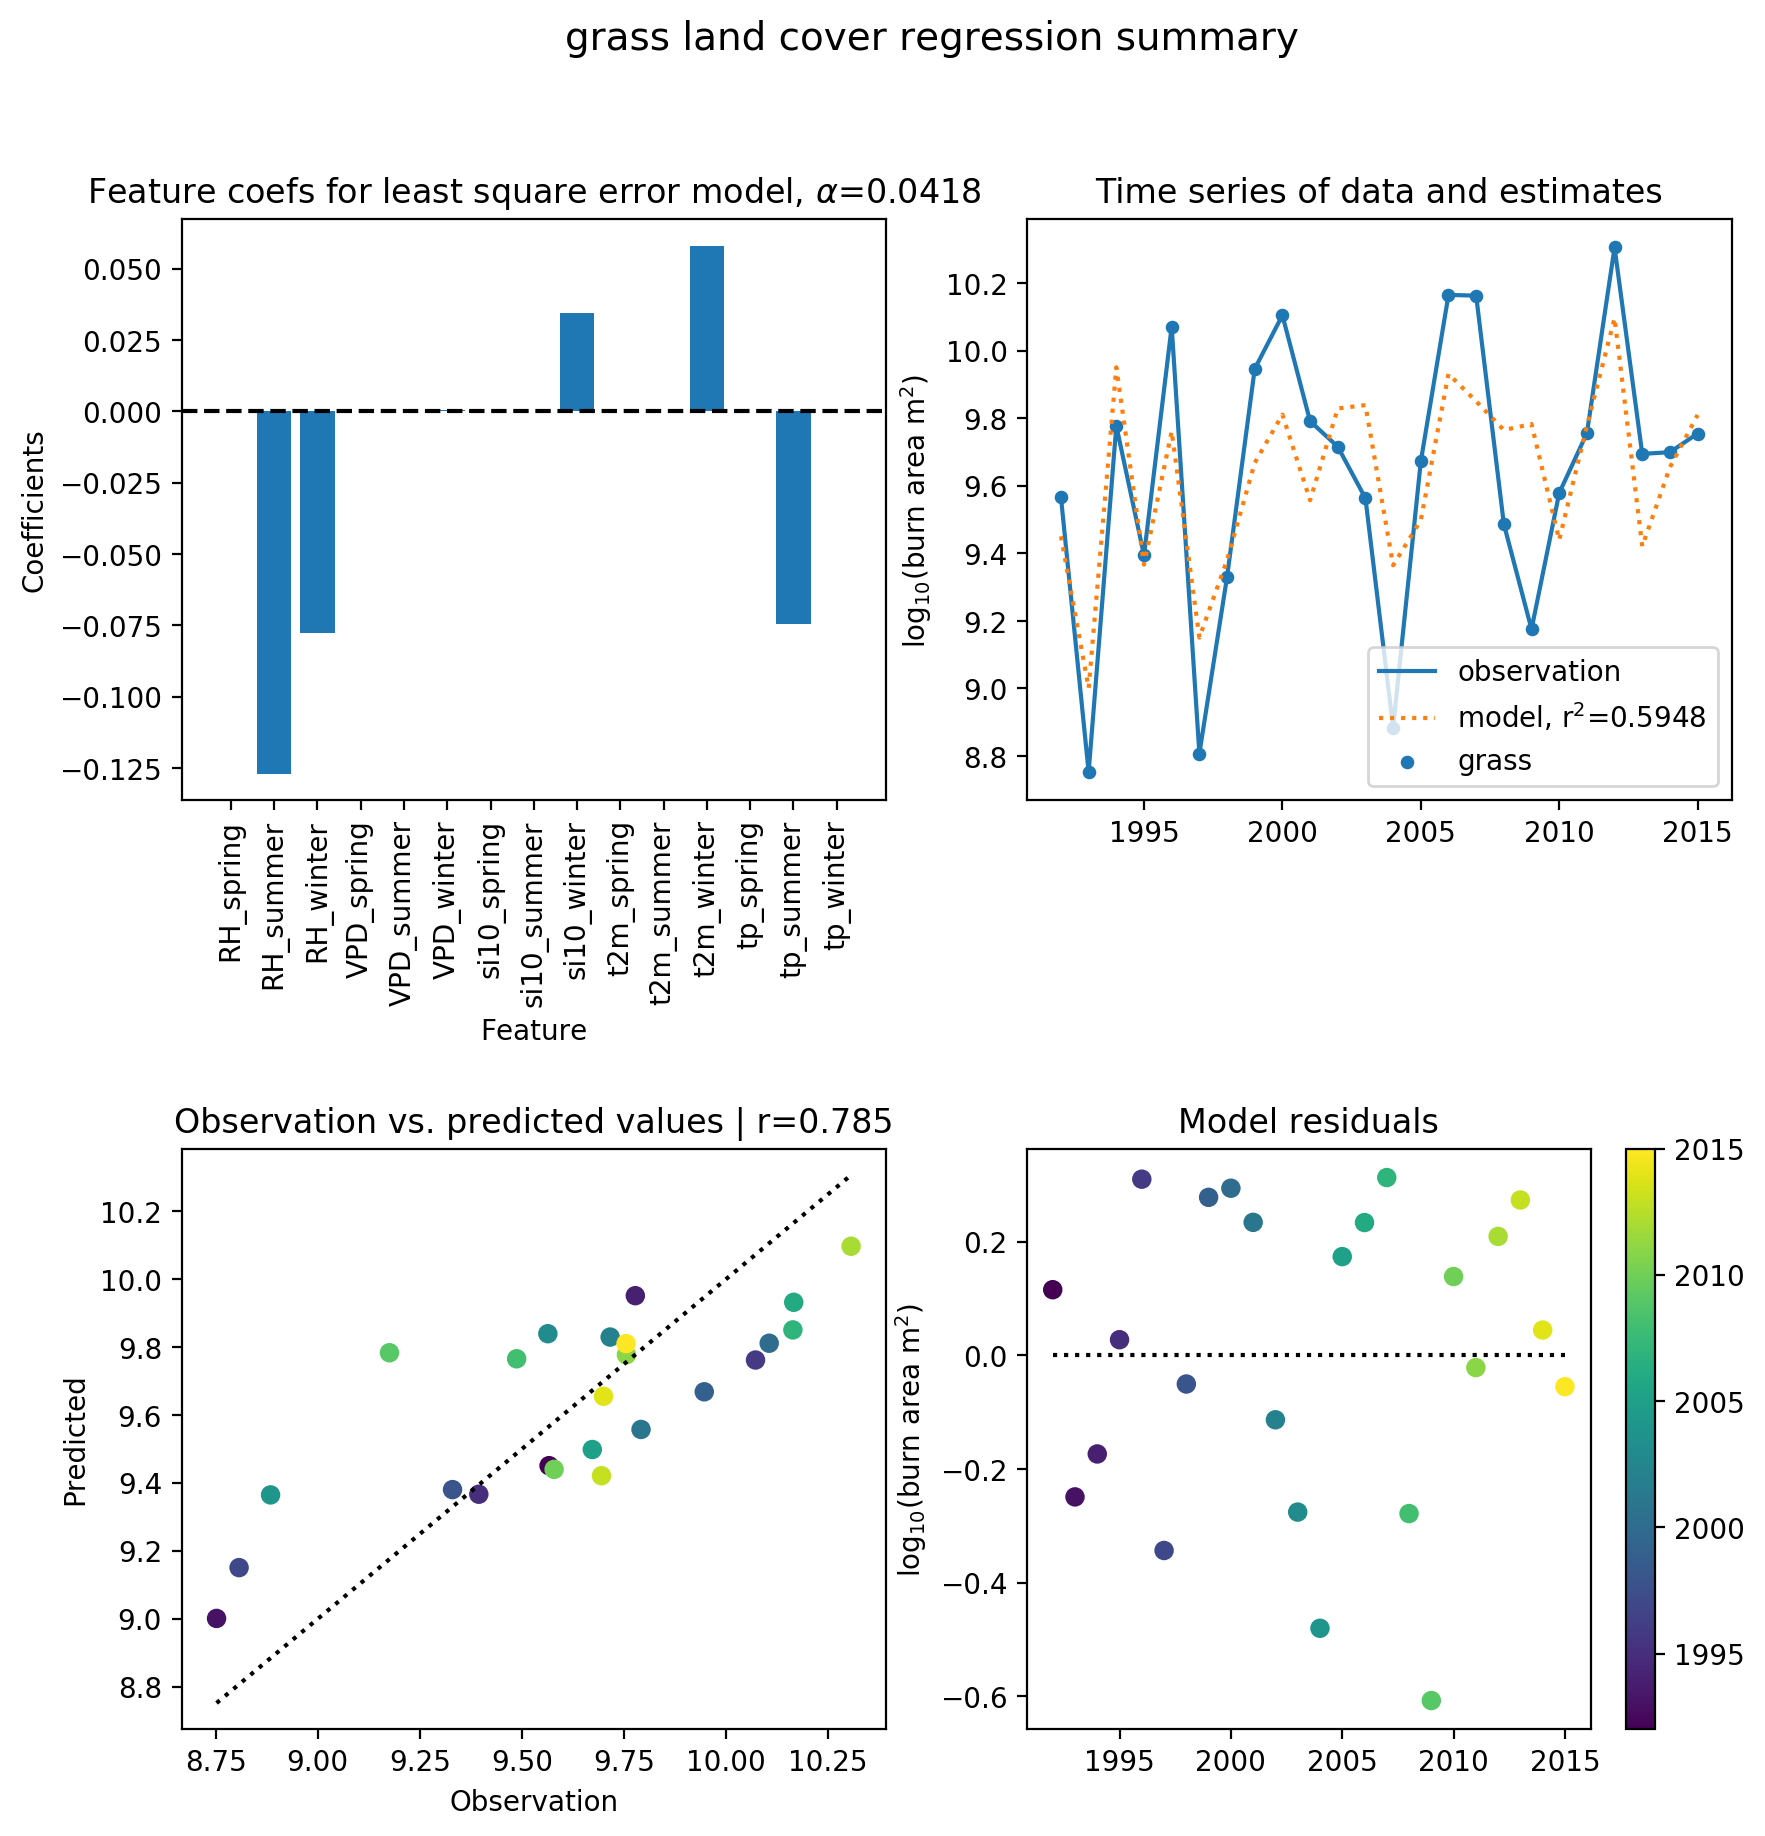

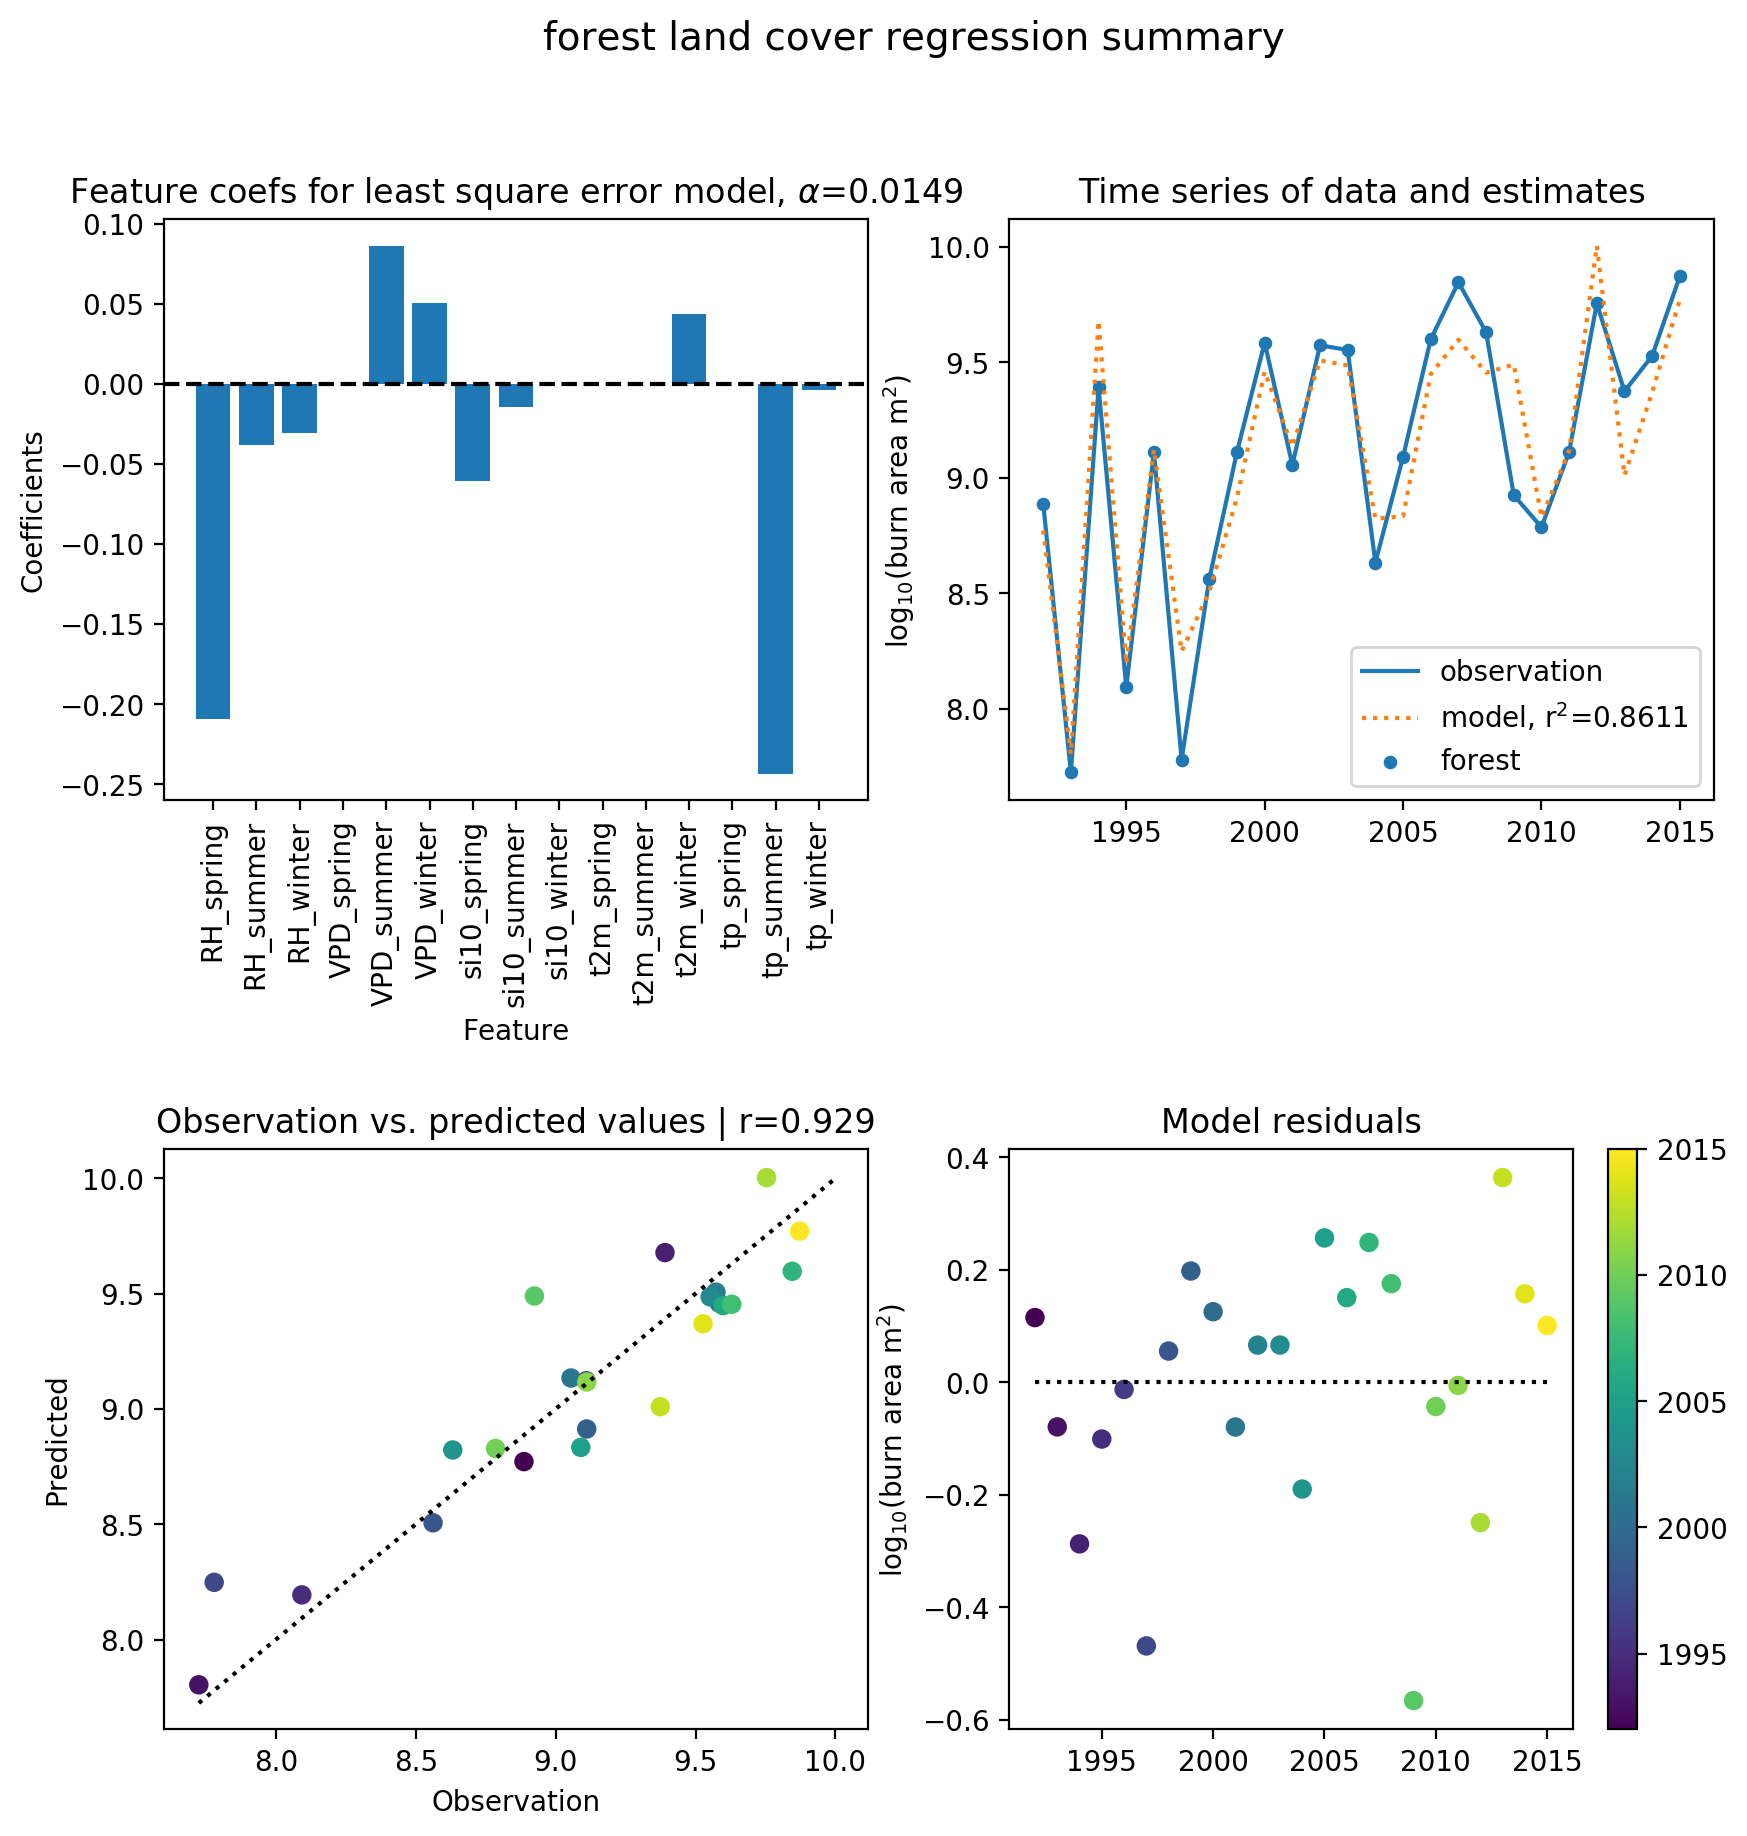

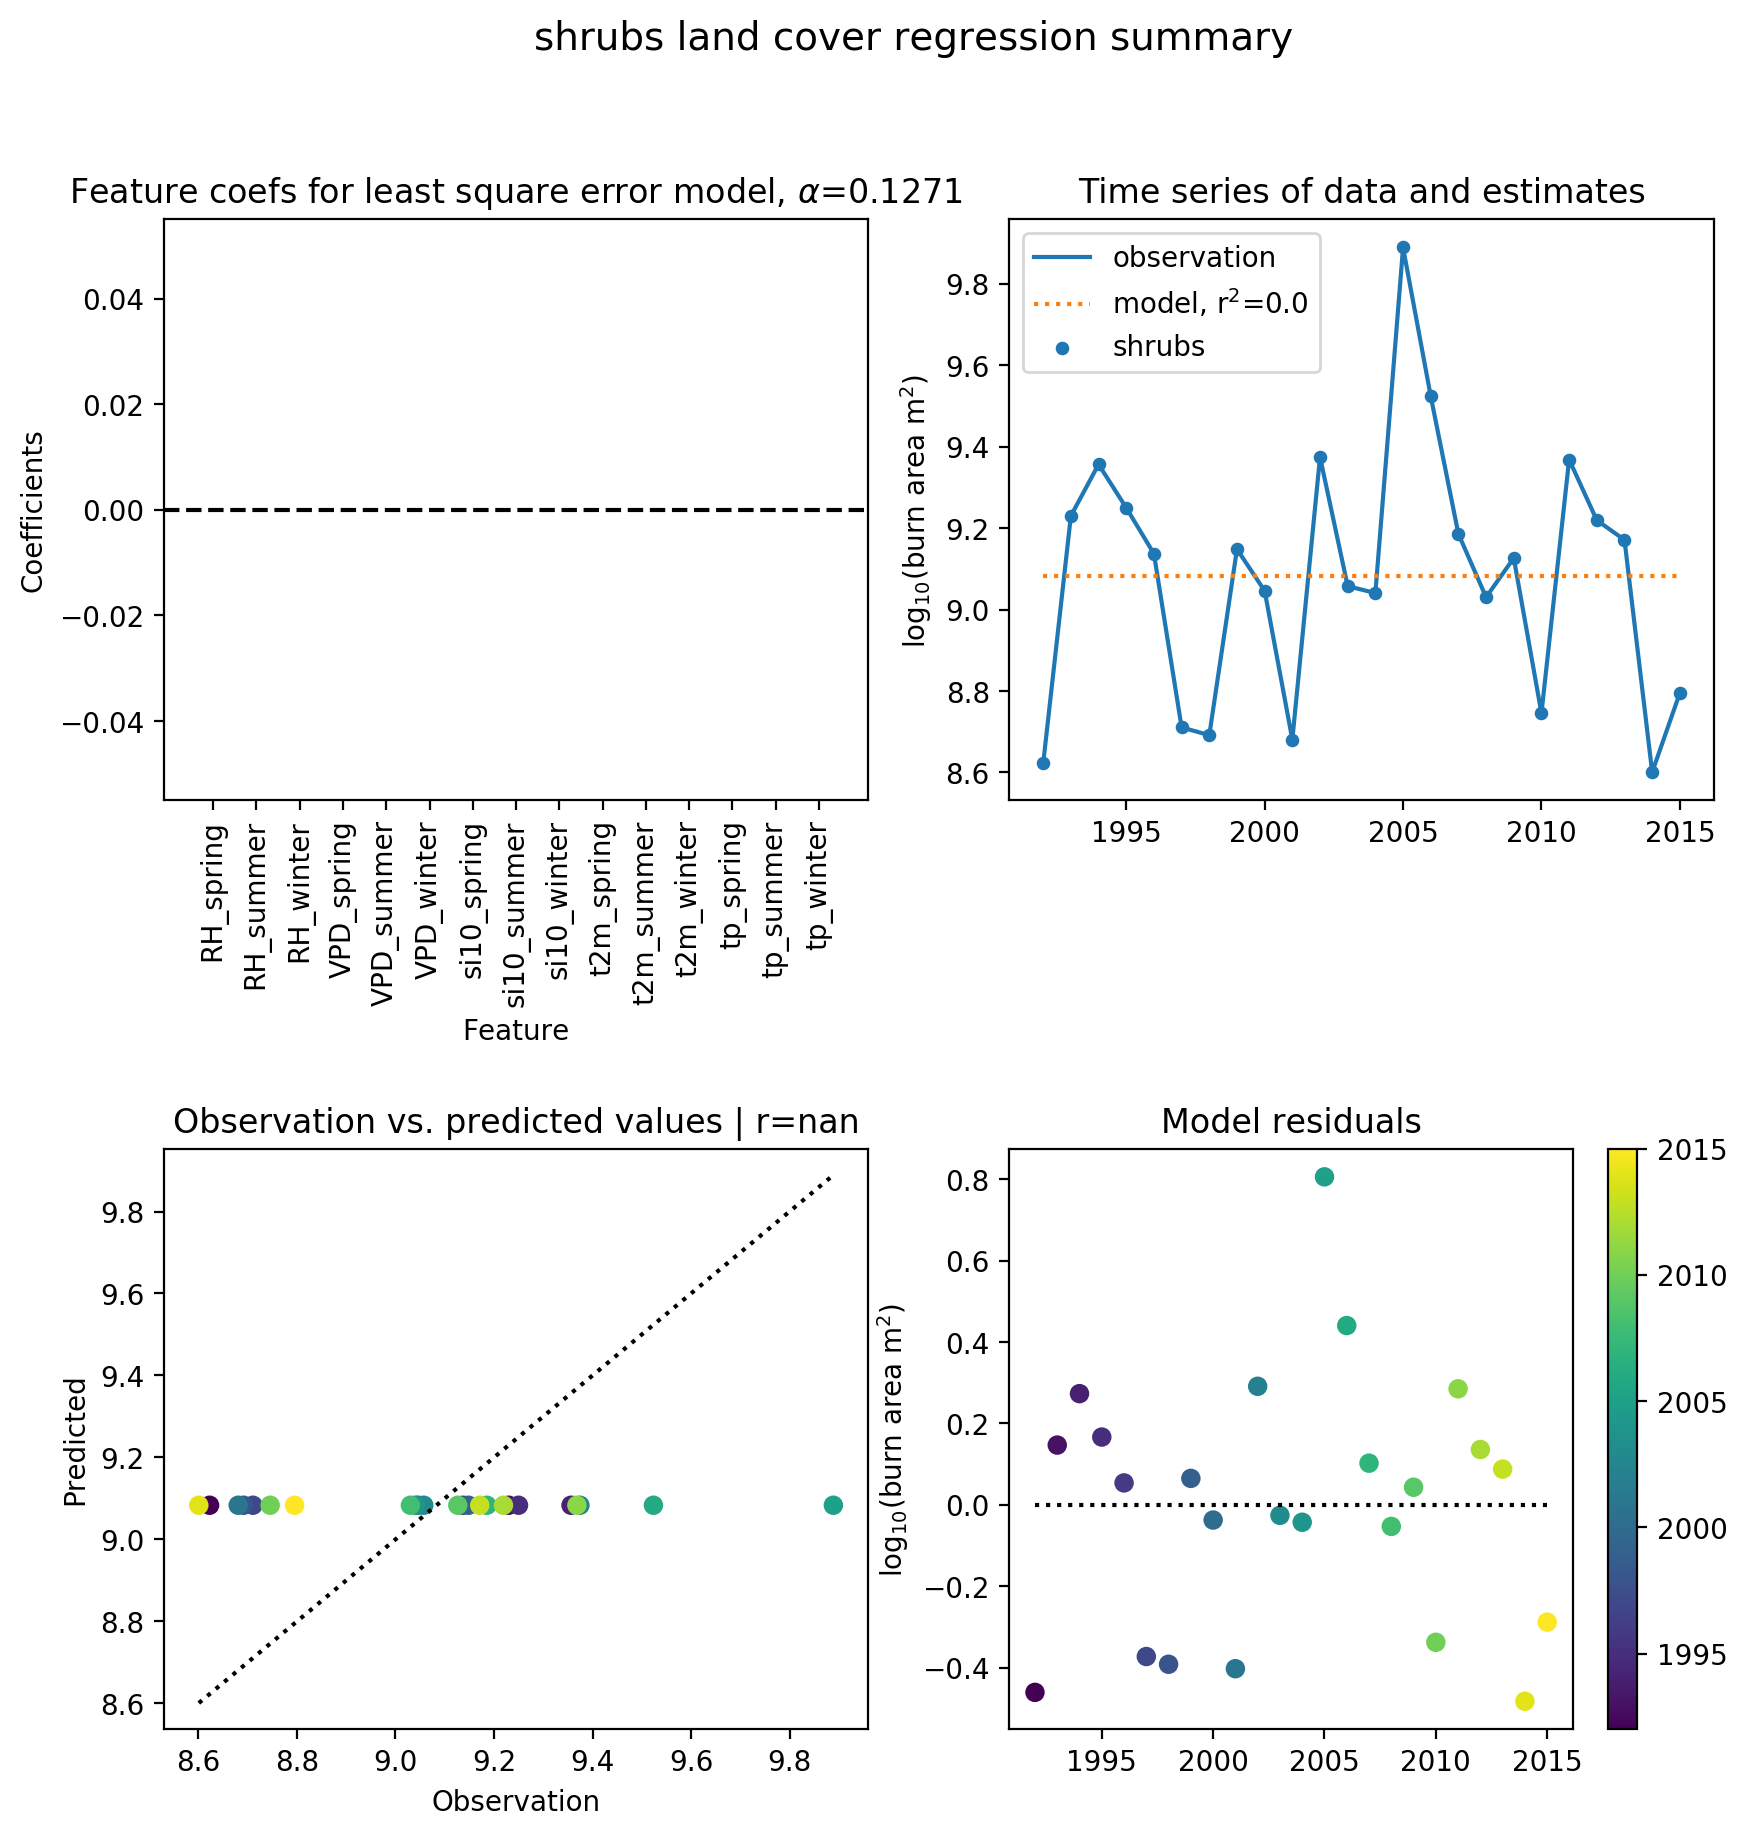

In [148]:
for target in alpha_CV_dict.keys() :
    show_model_skill(target=target, 
                     y=np.log10(df_targets[target]), 
                     Z=Z, 
                     alpha_best=alpha_CV_dict[target], 
                     years=years)

### Add antecedent predictors 